In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import random

from xgboost import plot_importance
from xgboost import XGBRegressor
import statsmodels.api as sm

from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv('merged_characteristics.csv')
keys = ['HIOS ID', 'IssuerId', 'County', 'State', 'FIPS County Code',
       'County Name']
bad_cols  = ['S1701_C01_058E','NationalNetwork_YEs','OutOfServiceAreaCoverageDescription']

#setup y
y_cols = ['Ever Enrolled Count']

#set up x
x_cols = []
for col in df.columns:
    if col not in y_cols and col not in keys and col not in bad_cols: 
        
        x_cols.append(col)

y = df[y_cols]
X = df[x_cols]

X = X/X.std()

In [4]:
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(sm.add_constant(X), y, test_size=test_size)

In [5]:
model = XGBRegressor(n_estimators=X_train.shape[1], max_depth=5, eta=.1, subsample=0.33, colsample_bytree=.9)
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, enable_categorical=False,
             eta=0.1, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.100000001,
             max_delta_step=0, max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=182, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.33,
             tree_method='exact', validate_parameters=1, verbosity=None)

mse Ever Enrolled Count    2.409390e+07
dtype: float64


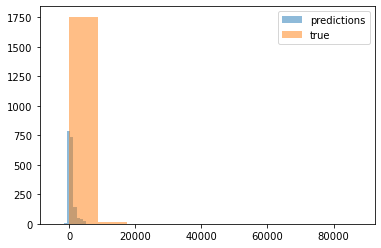

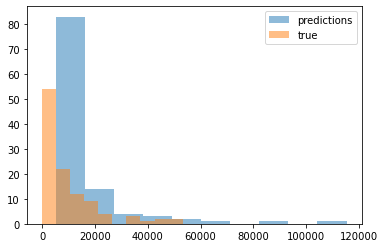

In [6]:
y_pred = model.predict(X_test)
y_pred = y_pred.reshape(X_test.shape[0],1)

print( 'mse', ((y_test - y_pred)**2).mean() ) 

#plot the difference between true and predicted
split = 5000

plt.hist(y_pred[y_pred < split],label='predictions',alpha=.5)
plt.hist(y_test[y_pred < split],label='true',alpha=.5)
plt.legend()
plt.show()

plt.hist(y_pred[y_pred > split],label='predictions',alpha=.5)
plt.hist(y_test[y_pred > split],label='true',alpha=.5)
plt.legend()
plt.show()

<BarContainer object of 20 artists>

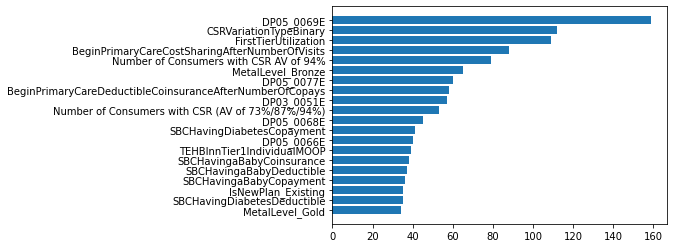

In [7]:
#use similar code for producing rankings of features according to LASSO

cols = np.array(X_test.columns)
importance_raw = model.get_booster().get_score(importance_type='weight')
importance = []

for key in importance_raw.keys():
    importance.append([key,importance_raw[key]])
    
importance  = pd.DataFrame( importance, columns=['features','score'])
importance = importance.sort_values('score',ascending=False)

plt.barh(importance.head(20)['features'].iloc[::-1], importance.head(20)['score'].iloc[::-1])

alpha_value: 50 mse 14186032.772444952


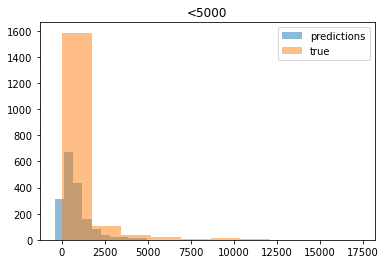

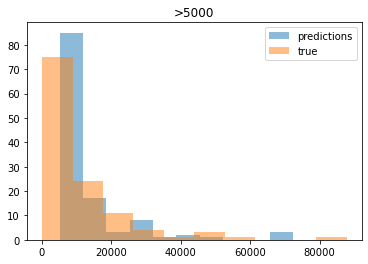

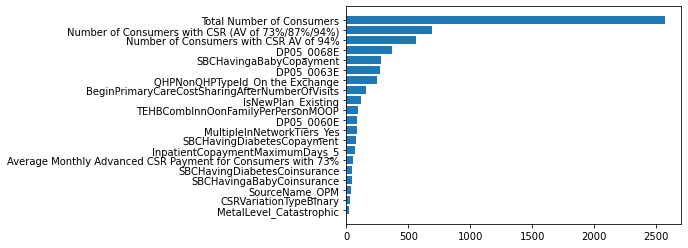

alpha_value: 100 mse 13996420.468729457


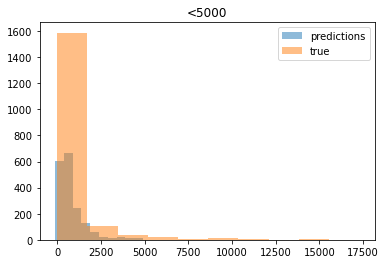

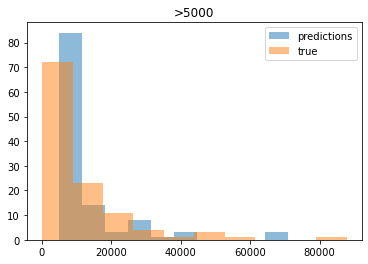

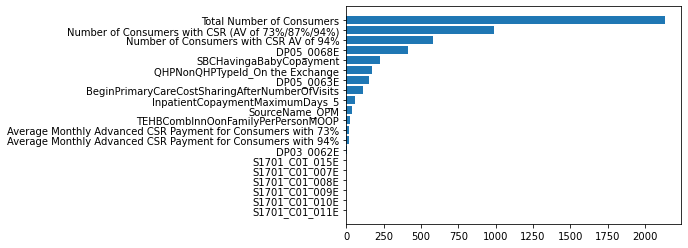

alpha_value: 150 mse 13836053.338783408


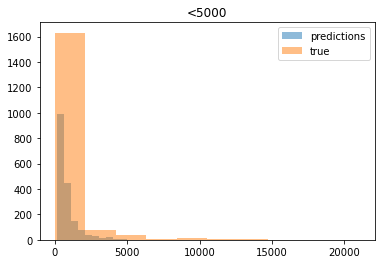

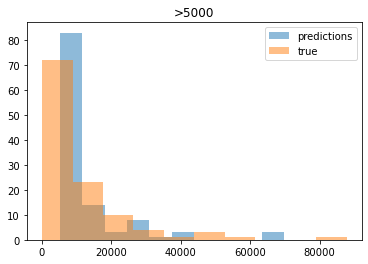

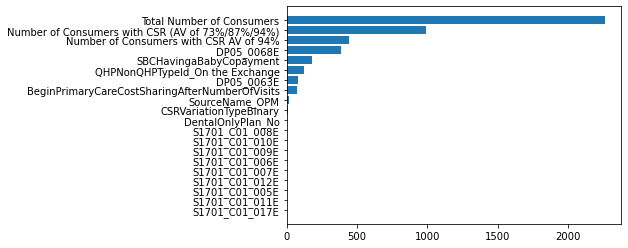

alpha_value: 200 mse 13692202.925748337


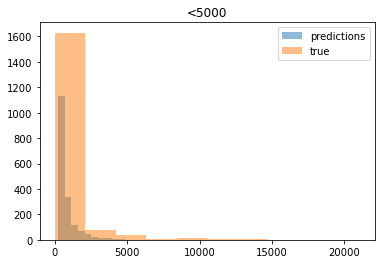

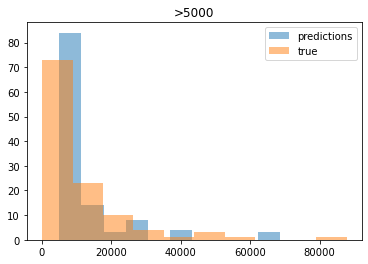

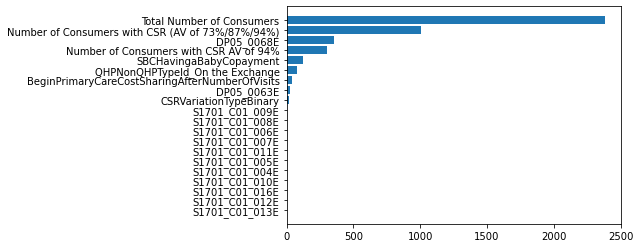

alpha_value: 250 mse 13538527.11880026


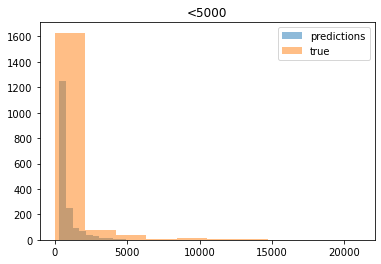

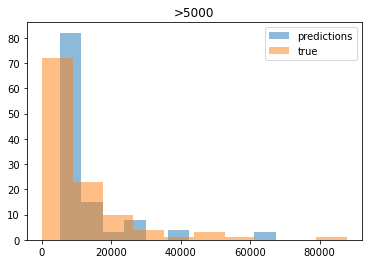

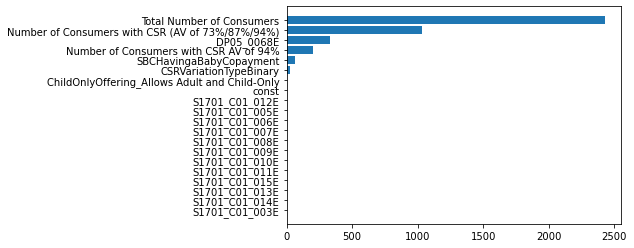

In [8]:
# Vary alpha values
a = [50,100,150,200,250]
for i in a: 
    lasso = sm.OLS(y_train, X_train).fit_regularized(method='elastic_net', alpha=i, L1_wt=1.0)
    y_pred = lasso.predict(X_test)
    print('alpha_value:', i, 'mse', ((np.array(y_test).reshape(y_pred.shape) - y_pred)**2).mean()) 
    
    #plot the difference between true and predicted
    split = 5000

    plt.hist(y_pred[y_pred < split],label='predictions',alpha=.5)
    plt.hist(y_test[y_pred < split],label='true',alpha=.5)
    plt.title('<5000')
    plt.legend()
    plt.show()

    plt.hist(y_pred[y_pred > split],label='predictions',alpha=.5)
    plt.hist(y_test[y_pred > split],label='true',alpha=.5)
    plt.legend()
    plt.title('>5000')
    plt.show()
    
    #also plot important feature
    param_df = pd.DataFrame(lasso.params,columns=['score']).sort_values(by=['score'], ascending=False).head(20)
    param_df['features'] = param_df.index
    plt.barh(param_df['features'].iloc[::-1], param_df['score'].iloc[::-1])
    plt.show()